<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Test_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

In [ ]:
!git clone https://github.com/deepmind/distrax.git
import sys
sys.path.append('/content/distrax')

Cloning into 'distrax'...
remote: Enumerating objects: 1459, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1459 (delta 1), reused 7 (delta 1), pack-reused 1447
Receiving objects: 100% (1459/1459), 569.32 KiB | 13.55 MiB/s, done.
Resolving deltas: 100% (809/809), done.


In [ ]:
!pip install optax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 15.4 MB/s 
     |████████████████████████████████| 85 kB 4.5 MB/s 


In [ ]:
import distrax
#import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds

In [ ]:
distrax.__version__

'0.1.2'

In [ ]:
def RQS_fn(params):
  return distrax.RationalQuadraticSpline(
        params, range_min=-3, range_max=3., boundary_slopes="identity")


In [ ]:
K = 6
num_par = 3*K+1

slope = jax.random.uniform(jax.random.PRNGKey(10),shape=(K+1,))

width  = jnp.linspace(0,1,K)
height = jnp.linspace(0,2,K)

params = jnp.hstack((width,height, slope))

num_bins = (params.shape[-1] - 1) // 3

print(num_bins)
# Extract unnormalized parameters.
unnormalized_bin_widths = params[..., :num_bins]
unnormalized_bin_heights = params[..., num_bins : 2 * num_bins]
unnormalized_knot_slopes = params[..., 2 * num_bins:]
print("Unorm W:",unnormalized_bin_widths)
print("Unorm H:",unnormalized_bin_heights)
print("Unorm Slope:",unnormalized_knot_slopes)

6
Unorm W: [0.  0.2 0.4 0.6 0.8 1. ]
Unorm H: [0.  0.4 0.8 1.2 1.6 2. ]
Unorm Slope: [0.39297736 0.28655386 0.5168655  0.8218564  0.00178742 0.07966435
 0.4261527 ]


In [ ]:
transf = RQS_fn(params)

In [ ]:
transf.x_pos,transf.y_pos, transf.knot_slopes

(DeviceArray([-3.        , -2.4273927 , -1.7280308 , -0.87385035,
               0.16942596,  1.4436646 ,  3.        ], dtype=float32),
 DeviceArray([-3.        , -2.705517  , -2.2662492 , -1.6109877 ,
              -0.6335015 ,  0.82468724,  3.        ], dtype=float32),
 DeviceArray([1.       , 1.190409 , 1.3561146, 1.5909644, 1.0011302,
              1.0510871, 1.       ], dtype=float32))

In [ ]:
x = jnp.linspace(-3.5,3.5,10_000)

In [ ]:
y = transf.forward(x)
yinv = transf.inverse(x)

In [ ]:
y_grad = jax.vmap(jax.grad(transf.forward))

In [ ]:
dist = distrax.Normal(loc=0., scale=1.)
samples = dist.sample(seed=0, sample_shape=(100_000,))
transformed_dist = distrax.Transformed(distribution=dist, bijector=transf)
trans_samples = transformed_dist.sample(seed=0, sample_shape=(1_000_000,))

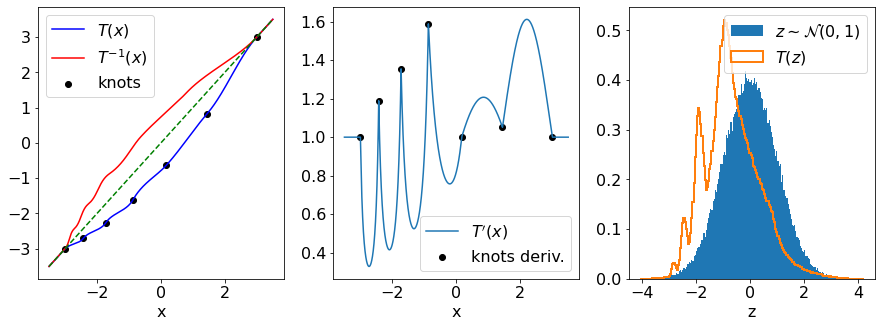

In [ ]:
fig, ax= plt.subplots(ncols=3,figsize=(15,5))

ax[0].plot(x,y,c="b",label="$T(x)$")
ax[0].plot(x,yinv,c="r",label="$T^{-1}(x)$")
ax[0].scatter(transf.x_pos,transf.y_pos, c="k",label="knots")
ax[0].plot(x,x,c="g",ls="--")
ax[0].legend()
ax[0].set_xlabel("x");


ax[1].plot(x,y_grad(x),label="$T^\prime(x)$")
ax[1].scatter(transf.x_pos,transf.knot_slopes, c='k',label="knots deriv.")
ax[1].set_xlabel("x")
ax[1].legend();


_,bins,_ = ax[2].hist(samples,bins=200, density=True,histtype='stepfilled',label="$z\sim\mathcal{N}(0,1)$")
ax[2].hist(trans_samples,bins=bins, density=True,histtype='step',lw=2,label="$T(z)$");
ax[2].set_xlabel("z")
ax[2].legend();


# With TensorFlow (JAX backend)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

import jax
import jax.numpy as jnp
import numpy as np
#import optax
import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow_probability.substrates import jax as tfp
tfb = tfp.bijectors
tfd = tfp.distributions


In [ ]:
K = 6
num_par = 3*K+1

slope = jax.random.uniform(jax.random.PRNGKey(10),shape=(K+1,))

width  = jnp.linspace(0,1,K)
height = jnp.linspace(0,2,K)

width, height

(DeviceArray([0. , 0.2, 0.4, 0.6, 0.8, 1. ], dtype=float32),
 DeviceArray([0. , 0.4, 0.8, 1.2, 1.6, 2. ], dtype=float32))

In [ ]:
def _normalize_bin_sizes(unnormalized_bin_sizes,
                         total_size,
                         min_bin_size=1e-4):
  """Make bin sizes sum to `total_size` and be no less than `min_bin_size`."""
  num_bins = unnormalized_bin_sizes.shape[-1]
  if num_bins * min_bin_size > total_size:
    raise ValueError(
        f'The number of bins ({num_bins}) times the minimum bin size'
        f' ({min_bin_size}) cannot be greater than the total bin size'
        f' ({total_size}).')
  bin_sizes = jax.nn.softmax(unnormalized_bin_sizes, axis=-1)
  return bin_sizes * (total_size - num_bins * min_bin_size) + min_bin_size


def _normalize_knot_slopes(unnormalized_knot_slopes,
                           min_knot_slope=1e-4):
  """Make knot slopes be no less than `min_knot_slope`."""
  # The offset is such that the normalized knot slope will be equal to 1
  # whenever the unnormalized knot slope is equal to 0.
  if min_knot_slope >= 1.:
    raise ValueError(f'The minimum knot slope must be less than 1; got'
                     f' {min_knot_slope}.')
  min_knot_slope = jnp.array(
      min_knot_slope, dtype=unnormalized_knot_slopes.dtype)
  offset = jnp.log(jnp.exp(1. - min_knot_slope) - 1.)
  return jax.nn.softplus(unnormalized_knot_slopes + offset) + min_knot_slope

In [ ]:
range_min=0.0
range_max=6.0
range_size = range_max - range_min
widths = _normalize_bin_sizes(width, range_size)
heights = _normalize_bin_sizes(height, range_size)
slopes = _normalize_knot_slopes(slope)
transf= tfb.RationalQuadraticSpline(widths, heights, slopes[1:-1], range_min=-3)


In [ ]:
widths

DeviceArray([0.5726073 , 0.6993619 , 0.85418046, 1.0432762 , 1.2742383 ,
             1.556336  ], dtype=float32)

In [ ]:
print(-3 + jnp.cumsum(widths, axis=-1))
print(-3 + jnp.cumsum(heights, axis=-1))
print(-3 + jnp.sum(widths, axis=-1))

[-2.4273927  -1.7280308  -0.87385035  0.16942596  1.4436646   3.0000005 ]
[-2.705517   -2.2662492  -1.6109877  -0.6335015   0.82468724  3.        ]
3.0


In [ ]:
transf.bin_widths

DeviceArray([0.5726073 , 0.6993619 , 0.85418046, 1.0432762 , 1.2742383 ,
             1.556336  ], dtype=float32)

In [ ]:
dist = tfd.Normal(loc=0., scale=1.0)
samples = dist.sample(seed=jax.random.PRNGKey(0), sample_shape=(100_000,))
transformed_dist = tfd.TransformedDistribution(dist, transf)
trans_samples = transformed_dist.sample(seed=jax.random.PRNGKey(0), sample_shape=(1_000_000,))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:505: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  shape, utils.numpy_dtype(dtype)))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:308: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.reshape(func(sorted_sequence_2d, values_2d).astype(out_type),


In [ ]:
x_pos = jnp.hstack((jnp.array([-3]),transf.range_min + jnp.cumsum(transf.bin_widths)))
y_pos = jnp.hstack((jnp.array([-3]),transf.range_min + jnp.cumsum(transf.bin_heights)))

In [ ]:
x_pos

DeviceArray([-3.        , -2.4273927 , -1.7280308 , -0.87385035,
              0.16942596,  1.4436646 ,  3.0000005 ], dtype=float32)

In [ ]:
slopes = jnp.hstack((jnp.array([1]),transf.knot_slopes,jnp.array([1])))

In [ ]:
y_grad = jax.vmap(jax.grad(transf.forward))

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:505: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  shape, utils.numpy_dtype(dtype)))
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:308: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return np.reshape(func(sorted_sequence_2d, values_2d).astype(out_type),
/usr/local/lib/python3.7/dist-pac

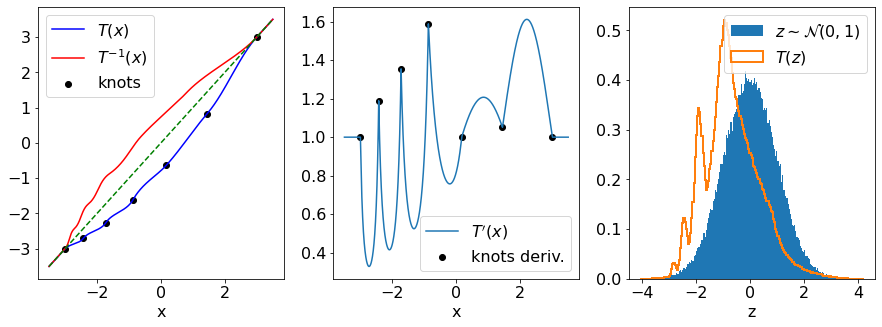

In [ ]:
x = jnp.linspace(-3.5,3.5,10_000)
y=transf.forward(x)
yinv=transf.inverse(x)


fig, ax= plt.subplots(ncols=3,figsize=(15,5))

ax[0].plot(x,y,c="b",label="$T(x)$")
ax[0].plot(x,yinv,c="r",label="$T^{-1}(x)$")
ax[0].scatter(x_pos,y_pos, c="k",label="knots")
ax[0].plot(x,x,c="g",ls="--")
ax[0].legend()
ax[0].set_xlabel("x");


ax[1].plot(x,y_grad(x),label="$T^\prime(x)$")
ax[1].scatter(x_pos,slopes, c='k',label="knots deriv.")
ax[1].set_xlabel("x")
ax[1].legend();


_,bins,_ = ax[2].hist(samples,bins=200, density=True,histtype='stepfilled',label="$z\sim\mathcal{N}(0,1)$")
ax[2].hist(trans_samples,bins=bins, density=True,histtype='step',lw=2,label="$T(z)$");
ax[2].set_xlabel("z")
ax[2].legend();


In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

import numpy as np
#import optax

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

In [ ]:
# code from example of tfp.bijectors.RationalQuadraticSpline
class MyRQS(tfb.RationalQuadraticSpline):
    def __init__(self, validate_args=False, name='MyRQS'):
      #interval_width  # Sum of bin widths.
      interval_width=10.
      range_min=-5.

      K = 3
      num_par = 3*K+1
      slopes = tf.random.uniform(shape=(K+1,))
      widths  = tf.linspace(0.,1.,K)
      heights = tf.linspace(0.,2.,K)
      
      #params = tf.concat([width,height, slope],axis=0)
      #num_bins = (self.params.shape[-1] - 1) // 3
      #unnormalized_bin_widths = self.params[..., :num_bins]
      #unnormalized_bin_heights = self.params[..., num_bins : 2 * num_bins]
      #unnormalized_knot_slopes = self.params[..., 2 * num_bins:]

      min_bin_size = 1e-3 # Bin width lower bound.
      min_knot_slope = 1e-3  # Lower bound for slopes at internal knots.


      bin_widths = tf.Variable(
          self._normalize_bin_sizes(widths, 
                                    interval_width,
                                    min_bin_size), name="w")
      
      bin_heights = tf.Variable(
          self._normalize_bin_sizes(heights, 
                                    interval_width,
                                    min_bin_size), name="h")

      knot_slopes = tf.Variable(
          self._normalize_knot_slopes(slopes,
                                      min_knot_slope)[1:-1], name="s")

      super(MyRQS, self).__init__(
          bin_widths=bin_widths, bin_heights=bin_heights,
          knot_slopes=knot_slopes, range_min=range_min,
            name=name)

    def _normalize_bin_sizes(self, unnormalized_bin_sizes,
                         total_size,
                         min_bin_size=1e-4):
        """Make bin sizes sum to `total_size` and be no less than `min_bin_size`.
        
        num_bins = unnormalized_bin_sizes.shape[-1]
        bin_sizes = jax.nn.softmax(unnormalized_bin_sizes, axis=-1)
        return bin_sizes * (total_size - num_bins * min_bin_size) + min_bin_size

        """
        num_bins = unnormalized_bin_sizes.shape[-1]
        bin_sizes = tf.math.softmax(unnormalized_bin_sizes, axis=-1)
        return bin_sizes * (total_size - num_bins * min_bin_size) + min_bin_size


    def _normalize_knot_slopes(self, unnormalized_knot_slopes,
                              min_knot_slope=1e-4):
      """Make knot slopes be no less than `min_knot_slope`.
      
            min_knot_slope = jnp.array(
          min_knot_slope, dtype=unnormalized_knot_slopes.dtype)
        offset = jnp.log(jnp.exp(1. - min_knot_slope) - 1.)
        return jax.nn.softplus(unnormalized_knot_slopes + offset) + min_knot_slope

      """
      # The offset is such that the normalized knot slope will be equal to 1
      # whenever the unnormalized knot slope is equal to 0.
      offset = tf.math.log(tf.math.exp(1. - min_knot_slope) - 1.)
      return tf.math.softplus(unnormalized_knot_slopes + offset) + min_knot_slope


In [ ]:
def _normalize_bin_sizes(unnormalized_bin_sizes,
                         total_size,
                         min_bin_size=1e-4):
        """Make bin sizes sum to `total_size` and be no less than `min_bin_size`.
        
        num_bins = unnormalized_bin_sizes.shape[-1]
        bin_sizes = jax.nn.softmax(unnormalized_bin_sizes, axis=-1)
        return bin_sizes * (total_size - num_bins * min_bin_size) + min_bin_size

        """
        num_bins = unnormalized_bin_sizes.shape[-1]
        bin_sizes = tf.math.softmax(unnormalized_bin_sizes, axis=-1)
        return bin_sizes * (total_size - num_bins * min_bin_size) + min_bin_size

def _normalize_knot_slopes(unnormalized_knot_slopes,
                              min_knot_slope=1e-4):
      """Make knot slopes be no less than `min_knot_slope`.
      
            min_knot_slope = jnp.array(
          min_knot_slope, dtype=unnormalized_knot_slopes.dtype)
        offset = jnp.log(jnp.exp(1. - min_knot_slope) - 1.)
        return jax.nn.softplus(unnormalized_knot_slopes + offset) + min_knot_slope

      """
      # The offset is such that the normalized knot slope will be equal to 1
      # whenever the unnormalized knot slope is equal to 0.
      offset = tf.math.log(tf.math.exp(1. - min_knot_slope) - 1.)
      return tf.math.softplus(unnormalized_knot_slopes + offset) + min_knot_slope





In [ ]:
interval_width=10.
range_min=-5.

tf.random.set_seed(1) # 5 ok 30 epochs
K = 3
num_par = 3*K+1
slopes = tf.random.uniform(shape=(K+1,),seed=10)
widths  = tf.linspace(0.,1.,K)
heights = tf.linspace(0.,2.,K)

#widths  = tf.random.uniform(shape=(K,),minval=0.,maxval=1.,seed=10)
#heights = tf.random.uniform(shape=(K,),minval=0.,maxval=2.,seed=10)#0.,2.,K)
      
#params = tf.concat([width,height, slope],axis=0)
#num_bins = (self.params.shape[-1] - 1) // 3
#unnormalized_bin_widths = self.params[..., :num_bins]
#unnormalized_bin_heights = self.params[..., num_bins : 2 * num_bins]
#unnormalized_knot_slopes = self.params[..., 2 * num_bins:]

min_bin_size = 1e-3 # Bin width lower bound.
min_knot_slope = 1e-3  # Lower bound for slopes at internal knots.


bin_widths = tf.Variable(
          _normalize_bin_sizes(widths, 
                                  interval_width,
                                  min_bin_size), name="w")
      
bin_heights = tf.Variable(
          _normalize_bin_sizes(heights, 
                                    interval_width,
                                    min_bin_size), name="h")

knot_slopes = tf.Variable(
          _normalize_knot_slopes(slopes,
                                      min_knot_slope)[1:-1], name="s")


In [ ]:
bin_widths

<tf.Variable 'w:0' shape=(3,) dtype=float32, numpy=array([1.8636783, 3.072037 , 5.0642843], dtype=float32)>

In [ ]:
transf = tfb.RationalQuadraticSpline(bin_widths=bin_widths, bin_heights=bin_heights,
          knot_slopes=knot_slopes, range_min=range_min,
            name="MyRQS")
inverse_transf = tfb.Invert(transf)

In [ ]:
transf.trainable_variables

(<tf.Variable 'h:0' shape=(3,) dtype=float32, numpy=array([0.90103555, 2.4475505 , 6.651413  ], dtype=float32)>,
 <tf.Variable 'w:0' shape=(3,) dtype=float32, numpy=array([1.8636783, 3.072037 , 5.0642843], dtype=float32)>,
 <tf.Variable 's:0' shape=(2,) dtype=float32, numpy=array([1.680535 , 1.6587552], dtype=float32)>)

In [ ]:
inverse_transf.trainable_variables

(<tf.Variable 'h:0' shape=(3,) dtype=float32, numpy=array([0.90103555, 2.4475505 , 6.651413  ], dtype=float32)>,
 <tf.Variable 'w:0' shape=(3,) dtype=float32, numpy=array([1.8636783, 3.072037 , 5.0642843], dtype=float32)>,
 <tf.Variable 's:0' shape=(2,) dtype=float32, numpy=array([1.680535 , 1.6587552], dtype=float32)>)

In [ ]:
x = tf.linspace(-5.5,5.5,10_000)
y = transf.forward(x)
y_inv = inverse_transf.forward(x)
z = transf.forward(y_inv)
np.alltrue(x == z)

True

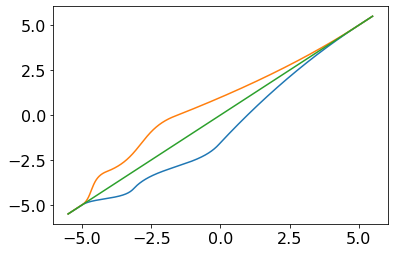

In [ ]:
plt.plot(x,y)
plt.plot(x,y_inv)
plt.plot(x,z)



In [ ]:
normal = tfd.Normal(loc=0.,scale=1.)
RQS_normal = transf(normal)#tfd.TransformedDistribution(normal,transf)
Inv_RQS_normal = inverse_transf(normal)

In [ ]:
spl = normal.sample(sample_shape=(100_000), seed=(1, 23))
spl_rqs = RQS_normal.sample(sample_shape=(100_000),seed=(1,24))
spl_inv_rqs = Inv_RQS_normal.sample(sample_shape=(100_000),seed=(1,25))


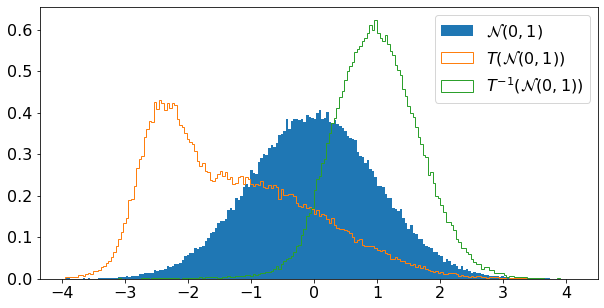

In [ ]:
fig = plt.subplots(figsize=(10,5))
_,bins,_=plt.hist(spl,bins=200, density=True,histtype='stepfilled', label="$\mathcal{N}(0,1)$" )
plt.hist(spl_rqs,bins=bins,density=True,histtype='step',label="$T(\mathcal{N}(0,1))$");
plt.hist(spl_inv_rqs,bins=bins,density=True,histtype='step', label="$T^{-1}(\mathcal{N}(0,1))$");
plt.legend();

In [ ]:
probs = [0.45,0.55]

mix_gauss = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(
          probs=probs),
      components_distribution=tfd.Normal(
        loc=[2.3, -1.5],       # One for each component.
        scale=[0.4, 0.4]))  # And same here.


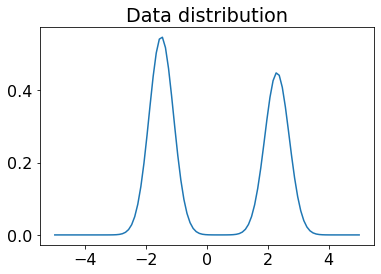

In [ ]:
x = tf.linspace(-5.0,5.0,100)
plt.plot(x,mix_gauss.prob(x))
plt.title('Data distribution')
plt.show()


In [ ]:
x_train = mix_gauss.sample(seed=(1,23),sample_shape=(10000,), name='train_spl')
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(seed=(1,24),sample_shape=(1000,), name='valid_spl')
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)


In [ ]:
trainable_inv_rqs = inverse_transf


In [ ]:
trainable_inv_rqs.trainable_variables

(<tf.Variable 'h:0' shape=(3,) dtype=float32, numpy=array([0.90103555, 2.4475505 , 6.651413  ], dtype=float32)>,
 <tf.Variable 'w:0' shape=(3,) dtype=float32, numpy=array([1.8636783, 3.072037 , 5.0642843], dtype=float32)>,
 <tf.Variable 's:0' shape=(2,) dtype=float32, numpy=array([1.680535 , 1.6587552], dtype=float32)>)

In [ ]:
trainable_dist = tfd.TransformedDistribution(normal,trainable_inv_rqs)


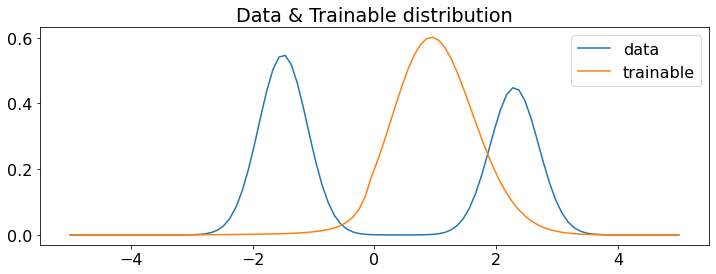

In [ ]:
x = np.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x,mix_gauss.prob(x),label='data')
plt.plot(x,trainable_dist.prob(x),label='trainable')
plt.title('Data & Trainable distribution')
plt.legend()
plt.show()


In [ ]:
num_epochs = 50
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

all_bin_h=[tf.convert_to_tensor(trainable_inv_rqs.trainable_variables[0]).numpy()]
all_bin_w =[tf.convert_to_tensor(trainable_inv_rqs.trainable_variables[1]).numpy()]
all_s=[tf.convert_to_tensor(trainable_inv_rqs.trainable_variables[2]).numpy()]

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    
    # Train
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_rqs.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_rqs.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_rqs.trainable_variables))
    train_losses.append(train_loss.result().numpy())
    #print(trainable_inv_rqs.trainable_variables)
    # save current param
    if epoch%5 == 0:
      all_bin_h.append(tf.convert_to_tensor(trainable_inv_rqs.trainable_variables[0]).numpy())
      all_bin_w.append(tf.convert_to_tensor(trainable_inv_rqs.trainable_variables[1]).numpy())
      all_s.append(tf.convert_to_tensor(trainable_inv_rqs.trainable_variables[2]).numpy())

        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())


Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...
Epoch 10...
Epoch 11...
Epoch 12...
Epoch 13...
Epoch 14...
Epoch 15...
Epoch 16...
Epoch 17...
Epoch 18...
Epoch 19...
Epoch 20...
Epoch 21...
Epoch 22...
Epoch 23...
Epoch 24...
Epoch 25...
Epoch 26...
Epoch 27...
Epoch 28...
Epoch 29...
Epoch 30...
Epoch 31...
Epoch 32...
Epoch 33...
Epoch 34...
Epoch 35...
Epoch 36...
Epoch 37...
Epoch 38...
Epoch 39...
Epoch 40...
Epoch 41...
Epoch 42...
Epoch 43...
Epoch 44...
Epoch 45...
Epoch 46...
Epoch 47...
Epoch 48...
Epoch 49...


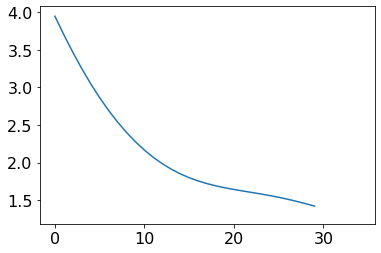

In [ ]:
#plt.plot(train_losses)
plt.plot(valid_losses)

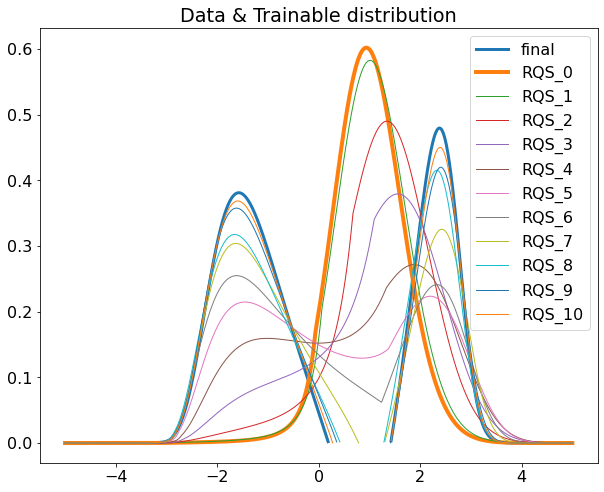

In [ ]:
x = np.linspace(-5,5,1000)
plt.figure(figsize=(10,8))
#plt.plot(x,mix_gauss.prob(x),label='data')
plt.plot(x,trainable_dist.prob(x),label='final',lw=3)
for i in range(len(all_s)):
  if i==0:
    lw=4
  else:
    lw=1
  transf = tfb.RationalQuadraticSpline(bin_widths=all_bin_w[i], bin_heights=all_bin_h[i],
            knot_slopes=all_s[i], range_min=range_min,
              name="RQS_"+str(i))
  inverse_transf = tfb.Invert(transf)
  trans_dist = tfd.TransformedDistribution(normal,inverse_transf)
  plt.plot(x,trans_dist.prob(x),lw=lw,label="RQS_"+str(i))
plt.title('Data & Trainable distribution')
plt.legend()
plt.show()

# Exercice https://seunghan96.github.io/bnn/code-10.Tensorflow-Probability-NF1/

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

import numpy as np
#import optax

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

In [ ]:
probs = [0.6,0.4]

true_dist = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(
          probs=probs),
      components_distribution=tfd.Normal(
        loc=[2.3, -0.8],       # One for each component.
        scale=[0.4, 0.4]))  # And same here.




In [ ]:
tf.Variable(tf.random.normal(shape=(1,)), name='w')

<tf.Variable 'w:0' shape=(1,) dtype=float32, numpy=array([-0.81041616], dtype=float32)>

In [ ]:

class Cubic(tfb.Bijector):
    def __init__(self, p, validate_args=False, name='Cubic'):

# Ok with _forward/_inverse/_forward_log_det_jacobian written with p[0],p[1]
        self.p = p 
        self.a = tf.cast(self.p[0], tf.float32)
        self.b = tf.cast(self.p[1], tf.float32)

# a,b tf.Variable OK
#        self.a = tf.Variable(0.25, name='a')
#        self.b = tf.Variable(-0.1, name='b')

# a & b as arg and init as tf.Variable each Ok
#        self.a = tf.cast(a, tf.float32)
#        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self,x):
        x = tf.cast(x,tf.float32)
        #return tf.squeeze(tf.pow(self.a*x + self.b,3))
        return tf.squeeze(tf.pow(self.p[0]*x + self.p[1],3))

    def _inverse(self,y):
        y = tf.cast(y,tf.float32)
#        return (tf.math.sign(y)*tf.pow(tf.abs(y),1/3)-self.b)/self.a
        return (tf.math.sign(y)*tf.pow(tf.abs(y),1/3)-self.p[1])/self.p[0]
    
    def _forward_log_det_jacobian(self,x):
        x = tf.cast(x,tf.float32)
#        return tf.math.log(3.*tf.abs(self.a))+2.*tf.math.log(tf.abs(self.a*x+self.b))
        return tf.math.log(3.*tf.abs(self.p[0]))+2.*tf.math.log(tf.abs(self.p[0]*x+self.p[1]))


In [ ]:
truef = Cubic(tf.Variable([1.,1e-5]), validate_args=True)
true_dist = tfd.TransformedDistribution(normal,tfb.Invert(truef))
x_train = true_dist.sample(seed=(1,23),sample_shape=(10_000,), name='train_spl')
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = true_dist.sample(seed=(1,24),sample_shape=(1000,), name='valid_spl')
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

In [ ]:
true_dist.sample(seed=(1,23),sample_shape=(10,))

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-0.7120981 , -1.059746  , -1.0300329 ,  0.5006797 , -0.7519198 ,
        0.80109924,  1.1149395 ,  1.1882936 ,  0.81423825, -0.81546474],
      dtype=float32)>

In [ ]:
transf = Cubic(tf.Variable([0.3,-0.1]))
trainable_inv_cubic = tfb.Invert(transf,validate_args=True)#tf.Variable(0.25),tf.Variable(-0.1)))

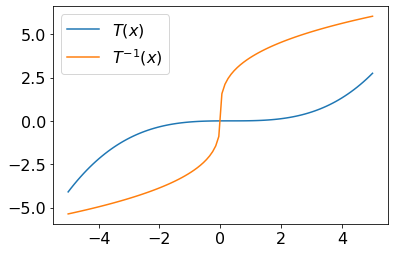

In [ ]:
x=np.linspace(-5,5,100)
plt.plot(x,transf.forward(x),label="$T(x)$")
plt.plot(x,transf.inverse(x),label="$T^{-1}(x)$")
plt.legend()

In [ ]:
trainable_inv_cubic.variables

(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.3, -0.1], dtype=float32)>,)

In [ ]:
tf.convert_to_tensor(trainable_inv_cubic.trainable_variables[0]).numpy()

array([ 0.3, -0.1], dtype=float32)

In [ ]:
# (1) Base distn
normal = tfd.Normal(loc=0.,scale=1.)

In [ ]:
trainable_dist = tfd.TransformedDistribution(normal,trainable_inv_cubic)

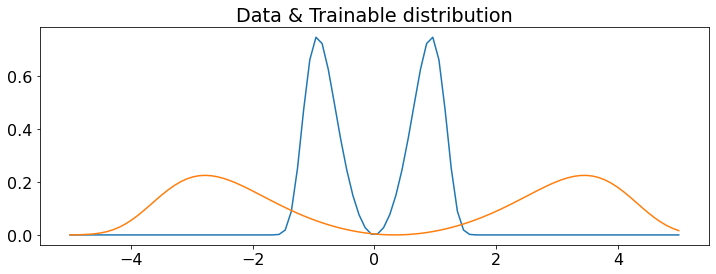

In [ ]:
x = np.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x,true_dist.prob(x),label='data')
plt.plot(x,trainable_dist.prob(x),label='trainable')
plt.title('Data & Trainable distribution')
plt.show()


In [ ]:
num_epochs = 10
opt = tf.keras.optimizers.Adam(learning_rate=5e-3)
train_losses = []
valid_losses = []

all_p=[tf.convert_to_tensor(trainable_inv_cubic.trainable_variables[0]).numpy()]

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    
    # Train
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
    all_p.append(tf.convert_to_tensor(trainable_inv_cubic.trainable_variables[0]).numpy())

    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())


Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


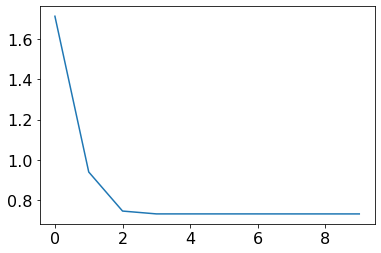

In [ ]:
#plt.plot(train_losses)
plt.plot(valid_losses)

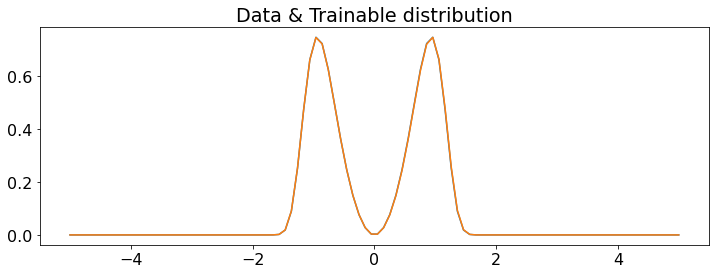

In [ ]:
x = np.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x,true_dist.prob(x),label='data')
plt.plot(x,trainable_dist.prob(x),label='trainable')
plt.title('Data & Trainable distribution')
plt.show()


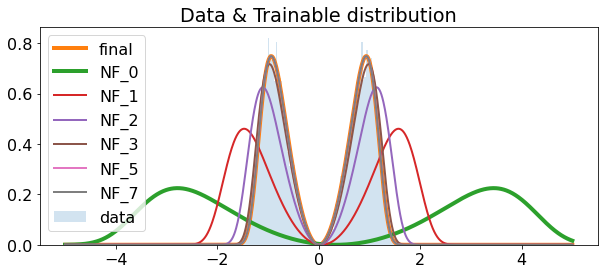

In [ ]:
x = np.linspace(-5,5,1000)
plt.figure(figsize=(10,4))
#plt.plot(x,true_dist.prob(x),label='data')
plt.hist(true_dist.sample(seed=(1,23),sample_shape=(10_000)),density=True,bins=100,alpha=0.2, label="data");
plt.plot(x,trainable_dist.prob(x),label='final',lw=4)
for i in [0,1,2,3,5,7]:
  if i==0:
    lw=4
  else:
    lw=2
  inverse_transf = tfb.Invert(Cubic(tf.Variable(all_p[i], name='p')))
  trans_dist = tfd.TransformedDistribution(normal,inverse_transf)
  plt.plot(x,trans_dist.prob(x),lw=lw,label="NF_"+str(i))
plt.title('Data & Trainable distribution')
plt.legend()
plt.show()

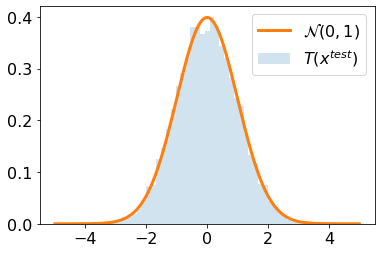

In [ ]:
plt.hist(inverse_transf.inverse(true_dist.sample(seed=(1,23),sample_shape=(10_000,), name='train_spl')).numpy(), 
         bins=50,density=True,label="$T(x^{test})$",alpha=0.2);
plt.plot(x,normal.prob(x),label="$\mathcal{N}(0,1)$",lw=3)
plt.legend();

In [ ]:
myBij = tfb.Chain([tfb.Tanh(),Cubic(tf.Variable([0.3,-0.2]))])

In [ ]:
myBij.trainable_variables

(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.3, -0.2], dtype=float32)>,)

In [ ]:
myBij_inv = tfb.Invert(myBij)

In [ ]:
myBij_inv.trainable_variables

(<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 0.3, -0.2], dtype=float32)>,)

In [ ]:
normal = tfd.Normal(loc=0.,scale=1.)
true_dist = tfd.TransformedDistribution(normal,myBij_inv)
x_train = true_dist.sample(seed=(1,23),sample_shape=(10_000,), name='train_spl')


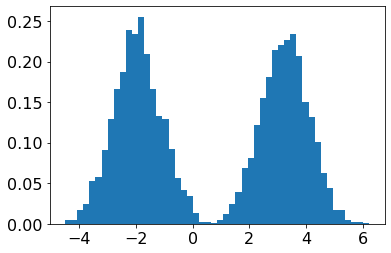

In [ ]:
plt.hist(x_train,density=True,bins=50);

## TF Jax version

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 16

import jax
import jax.numpy as jnp
import numpy as np
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import tensorflow.compat.v2 as tf

In [ ]:
class Cubic(tfb.Bijector):
    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = jnp.atleast_1d(a)
        self.b = jnp.atleast_1d(b)
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)
        
    def _forward(self,x):
        return jnp.squeeze(jnp.power(self.a*x + self.b,3))
    
    def _inverse(self,y):
        return (jnp.sign(y)*jnp.power(jnp.abs(y),1/3)-self.b)/self.a
    
    def _forward_log_det_jacobian(self,x):
        return jnp.log(3.*jnp.abs(self.a))+2.*jnp.log(jnp.abs(self.a*x+self.b))


In [ ]:
cubic = Cubic([0.25],[-0.1])

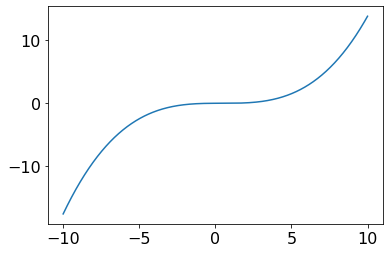

In [ ]:
x = jnp.linspace(-10,10,500).reshape(-1,1)
plt.plot(x,cubic.forward(x)) 
plt.show()


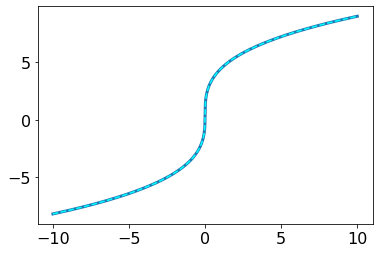

In [ ]:
plt.plot(x,cubic.inverse(x),lw=3)
plt.plot(x,tfb.Invert(cubic).forward(x),ls="--",c="cyan")
plt.show()


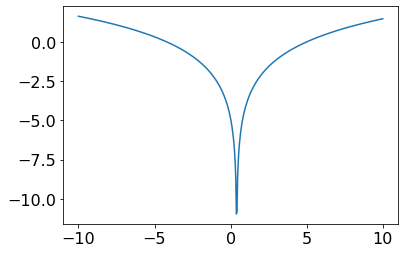

In [ ]:
plt.plot(x,cubic.forward_log_det_jacobian(x,event_ndims=0))
plt.show()


In [ ]:
probs = [0.45,0.55]
mix_gauss = tfd.MixtureSameFamily(
      mixture_distribution=tfd.Categorical(
          probs=probs),
      components_distribution=tfd.Normal(
        loc=[2.3, -0.8],       # One for each component.
        scale=[0.4, 0.4]))  # And same here.

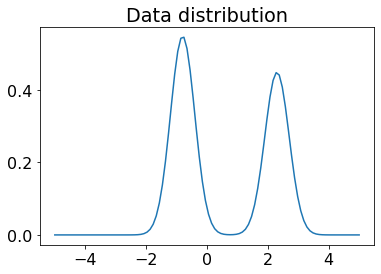

In [ ]:
x = jnp.linspace(-5.0,5.0,100)
plt.plot(x,mix_gauss.prob(x))
plt.title('Data distribution')
plt.show()


In [ ]:
x_train = mix_gauss.sample(10000, seed = jax.random.PRNGKey(0))
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000, seed = jax.random.PRNGKey(1))
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)


In [ ]:
trainable_inv_cubic = tfb.Invert(Cubic(a=0.25,b=-0.1))
# (1) Base distn
normal = tfd.Normal(loc=0.,scale=1.)
# trainable distrib
trainable_dist = tfd.TransformedDistribution(normal,trainable_inv_cubic)

In [ ]:
trainable_inv_cubic.trainable_variables

[]

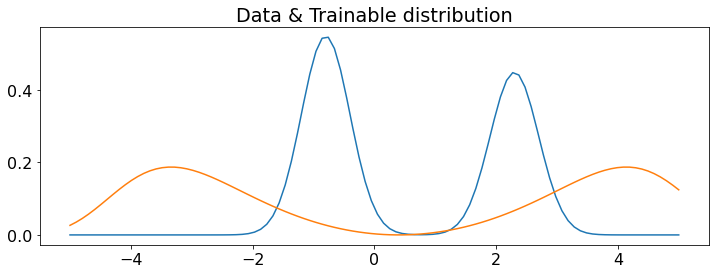

In [ ]:
x = jnp.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x,mix_gauss.prob(x),label='data')
plt.plot(x,trainable_dist.prob(x),label='trainable')
plt.title('Data & Trainable distribution')
plt.show()


In [ ]:
num_epochs = 10
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    
    # Train
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())


Epoch 0...


AttributeError: ignored